In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
tickets = first_table['Symbol'].values.tolist()
tickets.remove('BRK.B')
tickets.remove('BF.B')

In [3]:
all_stocks = []
for ticket in tickets:
    all_stocks.append(pd.read_csv('../datasets/yahoo/' + ticket + '.csv'))

In [4]:
def prepare_data(X, timerange=30, split=0.1):
    
    train_size = int(X.shape[0] * (1 - split))
    train_size = min(train_size, X.shape[0] - timerange)
    
    test_size = X.shape[0] - train_size - timerange
    
    X_train = np.ndarray(shape=(train_size, timerange))
    Y_train = np.ndarray(shape=(train_size))
    for i in range(train_size):
        X_train[i] = X[i:i+timerange]
        Y_train[i] = 1 if X[i+timerange-1] < X[i+timerange] else 0
    
    X_test = np.ndarray(shape=(test_size, timerange))
    Y_test = np.ndarray(shape=(test_size))
    for i in range(test_size):
        X_test[i] = X[train_size+i:train_size+i+timerange]
        Y_test[i] = 1 if X[train_size+i+timerange-1] < X[train_size+i+timerange] else 0
    
    return X_train, Y_train, X_test, Y_test

In [5]:
X_train, X_test = [np.ndarray(shape=(0, 30)) for i in range(2)]
Y_train, Y_test = [np.ndarray(shape=(0)) for i in range(2)]
for stock in all_stocks:
    x_train, y_train, x_test, y_test = prepare_data(stock['Close'].copy())
    X_train = np.append(X_train, x_train, axis=0)
    Y_train = np.append(Y_train, y_train, axis=0)
    X_test = np.append(X_test, x_test, axis=0)
    Y_test = np.append(Y_test, y_test, axis=0)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

limit = 1500

X = StandardScaler().fit_transform(X_train[:limit])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

(723, 2) (777, 2)


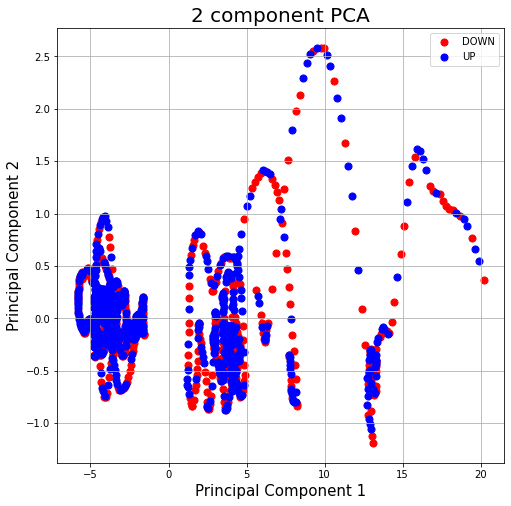

In [7]:
DOWN = np.ndarray(shape=(X.shape[0], 2))
UP = np.ndarray(shape=(X.shape[0], 2))

num_down, num_up = 0, 0

for i in range(X.shape[0]):
    if Y_train[i] == 0:
        DOWN[num_down] = principalComponents[i]
        num_down += 1
    else:
        UP[num_up] = principalComponents[i]
        num_up += 1

DOWN = DOWN[:num_down]
UP = UP[:num_up]
        
print(DOWN.shape, UP.shape)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [DOWN, UP]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    ax.scatter(target[:, 0], target[:, 1]
               , c = color
               , s = 50)
ax.legend(['DOWN', 'UP'])
ax.grid()

In [8]:
from sklearn.neighbors import KNeighborsClassifier

clfknn = KNeighborsClassifier(n_neighbors=3)
clfknn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [9]:
clfknn.score(X_test, Y_test)

0.5039731929152704

In [10]:
count = X_test.shape[0]
preds = clfknn.predict(X_test)
correct = 0

for i in range(count):
    correct += (preds[i] == Y_test[i])
    
print('KNN correct: %d/%d' % (correct, count))

KNN correct: 5264/10445


In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

model_deep = Sequential()
model_deep.add(Dense(2000, input_dim=30, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(rate=0.2))
model_deep.add(Dense(200, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(rate=0.2))
model_deep.add(Dense(1, activation='relu'))

model_deep.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [40]:
model_deep.fit(X_train, Y_train, epochs=100, batch_size=128)

Epoch 1/100
1777/1777 [==============================] - 12s 7ms/step - loss: 4.6063 - accuracy: 0.4921
Epoch 2/100
1777/1777 [==============================] - 12s 7ms/step - loss: 3.7991 - accuracy: 0.4946
Epoch 3/100
1777/1777 [==============================] - 14s 8ms/step - loss: 3.5251 - accuracy: 0.4969
Epoch 4/100
1777/1777 [==============================] - 13s 7ms/step - loss: 3.7810 - accuracy: 0.5000
Epoch 5/100
1777/1777 [==============================] - 13s 7ms/step - loss: 3.2272 - accuracy: 0.5014
Epoch 6/100
1777/1777 [==============================] - 13s 7ms/step - loss: 3.1858 - accuracy: 0.4987
Epoch 7/100
1777/1777 [==============================] - 14s 8ms/step - loss: 3.2063 - accuracy: 0.4990
Epoch 8/100
1777/1777 [==============================] - 13s 7ms/step - loss: 2.9338 - accuracy: 0.5012
Epoch 9/100
1777/1777 [==============================] - 13s 8ms/step - loss: 2.9671 - accuracy: 0.4989
Epoch 10/100
1777/1777 [==============================] - 13s 7m

KeyboardInterrupt: 